This is a script with instructions to read and plot the .lis outputs from the Athena 4.2 particle module. The structure is adapted (by P. Pjanka) from the \*.m files within this folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import struct # for reading binary data
import sys
import glob
from tqdm import tqdm # progress bar

# path to folder containing the .lis files
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2-particles/bin/test000_dragxy/'

filenames = sorted(glob.glob(datapath + '*.lis'))

In [2]:
class Particles:
    
    def __init__ (self): # empty class
        self.initialized = False
        self.npart = 0
        self.nparttypes = 0
        self.coords = {}
        self.times = []
        self.dts = []
        # arrays with particle data:
        #   [ dimensions: <time> <particle> <quantity> ]
        self.pos = []
        self.vel = []
        self.dpar = []
        self.grp = []
        self.my_id = []
        self.init_id = []
        # auxiliary data calculated from the above
        self.Ekin = []
        
    def process_metadata (self):
        # Read the coordinate limits
        x1l, x1u, x2l, x2u, x3l, x3u, \
        x1dl, x1du, x2dl, x2du, x3dl, x3du = struct.unpack('f'*12, self.file.read(4*12))
        coords = {'x1min': x1l, 'x1max': x1u, \
                  'x2min': x2l, 'x1max': x3u, \
                  'x2min': x2l, 'x1max': x3u}
        # Read particle property info
        nparttypes, = struct.unpack('i', self.file.read(4))
        grproperty = []
        for pt in range(nparttypes):
            grproperty.append(struct.unpack('f', self.file.read(4))[0])
        # Read time
        time, dt = struct.unpack('f'*2, self.file.read(4*2))
        # Read particle number
        npart, = struct.unpack('l', self.file.read(8))
        if self.initialized: # check for consistency
            if self.npart != npart or self.nparttypes != self.nparttypes or self.coords != coords:
                print('ERROR: metadata mismatch, aborting.', flush=True)
                sys.exit(1)
        else: # initialize metadata
            self.npart = npart
            self.nparttypes = nparttypes
            self.coords = coords
        # time and dt will be added along with the whole snapshot
        return time, dt
    
    def add_snapshot (self, filename, verbose=True):
        
        if verbose:
            print(" - adding snapshot %s... " % filename, flush=True, end='')
        
        # Read from the file
        self.file = open(filename, 'rb')
            
        time, dt = self.process_metadata()

        # Read all particle data

        data_type_vector = np.dtype([('x1', np.float32), ('x2', np.float32), ('x3', np.float32)])
        data_type = np.dtype([('pos', data_type_vector), ('vel', data_type_vector), ('dpar', np.float32), ('gr_property', np.int32), ('my_id', np.int64), ('init_id', np.int32)])

        buffer = np.frombuffer(self.file.read(data_type.__sizeof__() *self.npart), dtype=data_type, count=self.npart)

        # organize buffer data (note extra dimension)
        buffer_pos = np.array([[list(x[0]) for x in buffer],])
        buffer_vel = np.array([[list(x[1]) for x in buffer],])
        buffer_dpar = np.array([[x[2] for x in buffer],])
        buffer_grp = np.array([[x[3] for x in buffer],])
        buffer_my_id = np.array([[x[4] for x in buffer],])
        buffer_init_id = np.array([[x[5] for x in buffer],])
        del buffer
        
        self.file.close()
        
        # Add data to the class structures
        if self.initialized: # add time slice
            self.times.append(time)
            self.dts.append(dt)
            self.pos = np.concatenate([self.pos, buffer_pos], axis=0)
            self.vel = np.concatenate([self.vel, buffer_vel], axis=0)
            self.dpar = np.concatenate([self.dpar, buffer_dpar], axis=0)
            self.grp = np.concatenate([self.grp, buffer_grp], axis=0)
            self.my_id = np.concatenate([self.my_id, buffer_my_id], axis=0)
            self.init_id = np.concatenate([self.init_id, buffer_init_id], axis=0)
        else: # initialize
            self.times.append(1.*time)
            self.dts.append(1.*dt)
            self.pos = 1.*buffer_pos
            self.vel = 1.*buffer_vel
            self.dpar = 1.*buffer_dpar
            self.grp = 1.*buffer_grp
            self.my_id = 1.*buffer_my_id
            self.init_id = 1.*buffer_init_id
            self.initialized = True
        del buffer_pos, buffer_vel, buffer_dpar, buffer_grp, buffer_my_id, buffer_init_id
          
        if verbose:
            print('done.', flush=True)
            
    def update_aux_data (self, to_update=['Ekin',]):
        if 'Ekin' in to_update:
            self.Ekin = 0.5 * np.sum((self.vel)**2, axis=-1)
            
    def plot_pos2D (self, ax, color_by='time', cmap='rainbow'):
        if color_by == 'time':
            for p in range(self.npart):
                ax.scatter(self.pos[:,p,0], self.pos[:,p,1], s=0.1, c=self.times, cmap=cmap)
        elif color_by == 'particle':
            c = cm.get_cmap(cmap, 128)
            for p in range(self.npart):
                ax.scatter(self.pos[:,p,0], self.pos[:,p,1], s=0.1, color=c(p/self.npart))
                
    def plot_Ekin_vs_time (self, ax, cmap='rainbow'):
        c = cm.get_cmap(cmap, 128)
        for p in range(self.npart):
            ax.scatter(self.times, self.Ekin[:,p], s=0.1, color=c(p/self.npart))

In [3]:
particles = Particles()
for filename in tqdm(filenames):
    particles.add_snapshot(filename, verbose=False)

100%|██████████| 1001/1001 [00:00<00:00, 5397.53it/s]


In [4]:
particles.pos.shape

(1001, 10, 3)

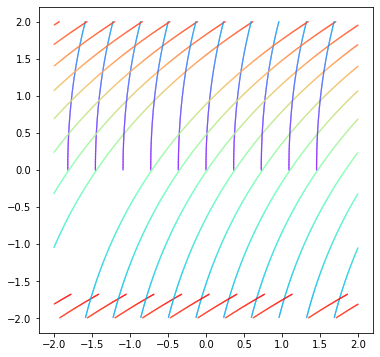

In [5]:
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
particles.plot_pos2D(ax, color_by='time')
plt.show()
plt.close()

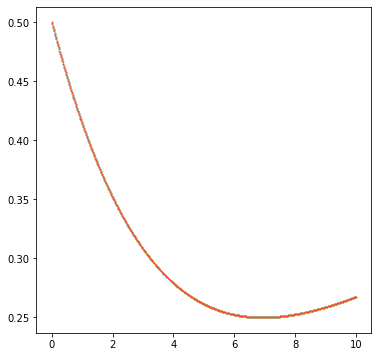

In [6]:
particles.update_aux_data()
fig = plt.figure(figsize=(6,6))
ax = plt.gca()
particles.plot_Ekin_vs_time(ax)
plt.show()
plt.close()

In [7]:
particles.vel.shape

(1001, 10, 3)

In [8]:
np.sum((particles.vel)**2, axis=-1)

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.997924  , 0.997924  , 0.997924  , ..., 0.997924  , 0.997924  ,
        0.997924  ],
       [0.9958545 , 0.9958545 , 0.9958545 , ..., 0.9958545 , 0.9958545 ,
        0.9958545 ],
       ...,
       [0.53452736, 0.53452736, 0.53452736, ..., 0.53452736, 0.53452736,
        0.53452736],
       [0.53472894, 0.53472894, 0.53472894, ..., 0.53472894, 0.53472894,
        0.53472894],
       [0.5349117 , 0.5349117 , 0.5349117 , ..., 0.5349117 , 0.5349117 ,
        0.5349117 ]], dtype=float32)